In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

## 0. Parameters <a name="parameters"></a>

In [309]:
NUM_CLASSES = 10

## 1. Prepare the Data <a name="prepare"></a>

In [310]:
# Download CIFAR10 dataset.
trainset_tensor = datasets.CIFAR10(root = './data', train=True, download=True, transform=ToTensor())
testset_tensor = datasets.CIFAR10(root = './data', train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [322]:
# Put into data loader.
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset_tensor, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_tensor, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [323]:
# Get tensors for use later.
x_train = trainset_tensor.data
y_train = trainset_tensor.targets
x_test = testset_tensor.data
y_test = testset_tensor.targets

In [324]:
# Normalize.
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# One hot encode.
y_train = np.eye(NUM_CLASSES, dtype='uint8')[y_train]
y_test = np.eye(NUM_CLASSES, dtype='uint8')[y_test]

## 2. Build the model <a name="build"></a>

In [325]:
# Create the model layer by layer.
# We dont need a statically defined input size here like in Tensorflow.
f1 = nn.Flatten()

l1 = nn.Linear(3072, 200)
r1 = nn.ReLU()

l2 = nn.Linear(200, 150)
r2 = nn.ReLU()

outl = nn.Linear(150, NUM_CLASSES)
s3 = nn.Softmax()

model = nn.Sequential(
    f1,
    l1,
    r1,
    l2,
    r2,
    outl,
    s3,
)

summary(model)

Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Linear: 1-2                            614,600
├─ReLU: 1-3                              --
├─Linear: 1-4                            30,150
├─ReLU: 1-5                              --
├─Linear: 1-6                            1,510
├─Softmax: 1-7                           --
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Linear: 1-2                            614,600
├─ReLU: 1-3                              --
├─Linear: 1-4                            30,150
├─ReLU: 1-5                              --
├─Linear: 1-6                            1,510
├─Softmax: 1-7                           --
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0

## 3. Train the model <a name="train"></a>

In [326]:
learning_rate=0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

torch.compile(model)
crossEntropyLoss = nn.CrossEntropyLoss()


In [327]:
#
# Training helper function
#

# The training loop is something we need to write ourserlves in pytorch. It is not an included method like with Keras in Tensorflow.
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device='cpu'):
    
    for epoch in range(epochs):

        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            # zero the parameter gradients
            optimizer.zero_grad()
            # get info from batch
            inputs, targets = batch
            # adjust for device (default is cpu)
            inputs = inputs.to(device)
            targets = targets.to(device)
            # feed forward
            output = model(inputs)
            # loss
            loss = loss_fn(output, targets)
            loss.backward()
            # backward
            optimizer.step()
            # update ongoing loss variable
            training_loss += loss.data.item()
        # trianing_loss /= len(train_iterator)
        training_loss /= len(train_loader)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Accuracy = {:.2f}'.format(epoch + 1, training_loss, valid_loss, num_correct / num_examples))
        

In [317]:
train(model, optimizer, crossEntropyLoss, trainloader, testloader, epochs=10)

/Users/steve/Documents/Dev/Books/gen_dl_foster_code__pytorch/generative-deep-learning-pytorch/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/var/folders/69/ncrrlk1j7510dx967flbkwmc0000gn/T/ipykernel_5213/4010618282.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 2.16, Validation Loss: 2.11, Accuracy = 0.34
Epoch: 2, Training Loss: 2.10, Validation Loss: 2.09, Accuracy = 0.37
Epoch: 3, Training Loss: 2.08, Validation Loss: 2.10, Accuracy = 0.35
Epoch: 4, Training Loss: 2.07, Validation Loss: 2.06, Accuracy = 0.40
Epoch: 5, Training Loss: 2.06, Validation Loss: 2.05, Accuracy = 0.41
Epoch: 6, Training Loss: 2.05, Validation Loss: 2.04, Accuracy = 0.41
Epoch: 7, Training Loss: 2.04, Validation Loss: 2.04, Accuracy = 0.42
Epoch: 8, Training Loss: 2.03, Validation Loss: 2.04, Accuracy = 0.42
Epoch: 9, Training Loss: 2.03, Validation Loss: 2.05, Accuracy = 0.40
Epoch: 10, Training Loss: 2.02, Validation Loss: 2.02, Accuracy = 0.43


## 4. Evaluation <a name="evaluate"></a>

In [328]:
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=150, bias=True)
  (4): ReLU()
  (5): Linear(in_features=150, out_features=10, bias=True)
  (6): Softmax(dim=None)
)

In [329]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

x_test_tensor = torch.from_numpy(x_test)
x_test_tensor = x_test_tensor.to(torch.float)

y_test_tensor = torch.FloatTensor(y_test)

preds = model(x_test_tensor)
preds_single = CLASSES[torch.argmax(preds, axis=-1)]
actual_single = CLASSES[y_test]

/Users/steve/Documents/Dev/Books/gen_dl_foster_code__pytorch/generative-deep-learning-pytorch/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


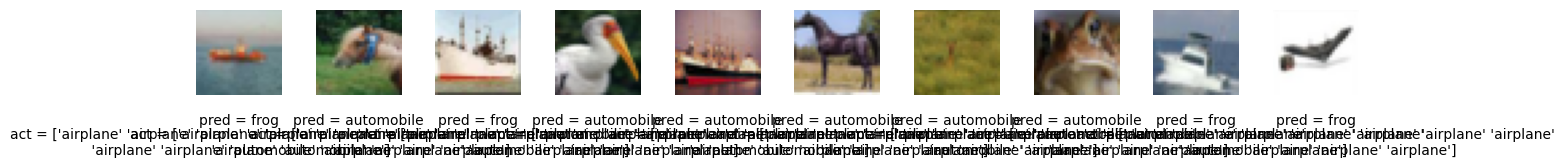

In [330]:
# Visualize the data.
# This perfoms not as well as we would like. We will improve it in the next nootbook.
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)